<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE32338](https://jckantor.github.io/CBE32338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE2338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Two State Model for a Single Heater

## Dynamics of the Heater/Sensor System

The previous results are not yet fully satisfactory. We're still missing the initial 'lag' in response of the measured temperature. 

For this third model, we consider the possibility that the heater and sensor may not be at the same temperature. In other words, that the heater/sensor assembly is not at a uniform temperature. To account for this possibility, we introduce $T_{H,1}$ to denote the temperature of heater one and $T_{S,1}$ to denote the temperature of the corresponding sensor. We'll further assume that sensor mainly exchanges heat with the heater, and the dominant heat transfer to the surroundings is through the heat sink attached to the heater.

This motivates a model

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_c(T_{S,1} - T_{H,1}) + P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_c(T_{H,1} - T_{S,1}) 
\end{align}

where $C^H_p$ and $C^S_p$ are the gross heat capacities of the heater and sensor, respectively, and $U_c$ is a new heat transfer coefficient characterizing the exchange of heat between the heater and sensor.

> **Question :** Dessiner le schéma nodal thermique équivalent à ces équations. 

## Model in deviation variables

Following the approach demonstrated in the first two models, we construct a model in terms of deviation from ambient temperature.

\begin{align}
\frac{dT_{H,1}'}{dt} & = -\frac{U_a+U_c}{C^H_p}T_{H,1}' + \frac{U_c}{C^H_p}T_{S,1}' + P_1u_1\\
\frac{dT_{S,1}'}{dt} & = \frac{U_c}{C^S_p}(T_{H,1}' - T_{S,1}') 
\end{align}

Next we jump right to the step of tuning the model parameters to fit the step response data.

In [13]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact

data = pd.read_csv('Step_Test_Data.csv').set_index('Time')[1:]
t = data.index
T1 = data['T1'].values
T2 = data['T2'].values

# known parameter values
P1 = 4
u1 = 0.5   # steady state value of u1 (fraction of total power)
P2 = 2
u2 = 0.0
T_ambient = 21

def compare(Ua, Uc, Cp_H, Cp_S):
    def deriv(T,t):
        T_H1, T_S1 = T
        dT_H1 = -(Ua + Uc)*T_H1/Cp_H + Uc*T_S1/Cp_H + P1*u1/Cp_H
        dT_S1 = Uc*T_H1/Cp_S - Uc*T_S1/Cp_S
        return [dT_H1, dT_S1]
    T = odeint(deriv, [0,0], t)
    # plot
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(t, T[:,1] + T_ambient, t, T1)
    plt.xlabel('Time / seconds')
    plt.ylabel('Temperature / °C')
    plt.title('Fitting model to Step Test Data for Heater 1')
    plt.grid()
    plt.text(300, 40, 'Ua = ' + str(Ua))
    plt.text(300, 35, 'Uc = ' + str(Uc))
    plt.text(300, 30, 'Cp_H = ' + str(Cp_H))
    plt.text(300, 25, 'Cp_S = ' + str(Cp_S))
    plt.subplot(2,1,2)
    plt.plot(t, T[:,1] + T_ambient - T1)
    plt.title('Model Error')
    plt.xlabel('Time / seconds')
    plt.ylabel('Temperature / °C')
    plt.grid()
    plt.tight_layout()

interact(compare, 
         Ua=(0,0.08,0.001), 
         Uc=(0,0.06,0.001), 
         Cp_H=(3,11,0.1), 
         Cp_S = (0.1,2,.01))

interactive(children=(FloatSlider(value=0.04, description='Ua', max=0.08, step=0.001), FloatSlider(value=0.03,…

<function __main__.compare(Ua, Uc, Cp_H, Cp_S)>

### Two State Model identification

\begin{align*}
C_p^H \frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_c(T_{S,1} - T_{H,1}) + P_1Q_1 \\
C_p^S \frac{dT_{S,1}}{dt} & = U_c(T_{H,1} - T_{S,1}) 
\end{align*}

In [18]:
def plot_data(t, T, T_pred, Q):
    
    fig = plt.figure(figsize=(8,5))
    grid = plt.GridSpec(4, 1)
    ax = [fig.add_subplot(grid[:2]), fig.add_subplot(grid[2]), fig.add_subplot(grid[3])]

    ax[0].plot(t, T, t, T_pred)
    ax[0].set_ylabel("deg C")
    ax[0].legend(["T", "T_pred"])
    
    ax[1].plot(t, T_pred - T)
    ax[1].set_ylabel("deg C")
    ax[1].legend(["T_pred - "])
    
    ax[2].plot(t, Q)
    ax[2].set_ylabel("%")
    ax[2].legend(["Q"])
    
    for a in ax: a.grid(True)
    ax[-1].set_xlabel("time / seconds")
    plt.tight_layout()
    


Heat transfer coefficient Ua = 0.06451612903225806 watts/degree C
Heat capacity = 11.612903225806452 J/deg C
[21.87, 11.612903225806452, 2.3225806451612905, 0.06451612903225806, 0.06451612903225806]


84.56857438208016

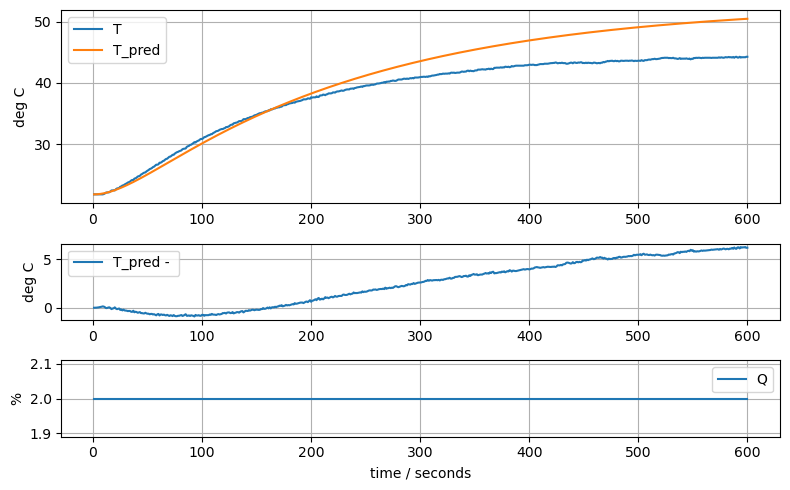

In [25]:
import numpy as np

K = 0.62 
tau = 180.0

P = 0.04

Ua = P/K
print("Heat transfer coefficient Ua =", Ua, "watts/degree C")

Cp = tau*P/K
print("Heat capacity =", Cp, "J/deg C")

def model_heater_sensor(param, plot=False):
    # access parameter values
    T_ambient, Cp_H, Cp_S, Ua, Uc = param
    
    P1 = 0.04*50

    
    def deriv(T, ti):
        T_H1, T_S1 = T
        dT_H1 = (Ua*(T_ambient - T_H1) + Uc*(T_S1 - T_H1) + P1)/Cp_H
        dT_S1 = Uc*(T_H1 - T_S1)/Cp_S
        return [dT_H1, dT_S1]
    T1_pred = odeint(deriv, [T_ambient, T_ambient], t)[:,1]

    # comparing to experimental data
    
    if plot:
        print(param)
        plot_data(t, T1, T1_pred, P1*np.ones(len(T1)))
    
    return np.linalg.norm(T1_pred - T1)

param_heater_sensor = [T1[0], Cp, Cp/5, Ua, Ua]
model_heater_sensor(param_heater_sensor, plot=True)



[21.69623178 11.64019389  1.28769796  0.08684473  0.05561025]


2.0210985524229756

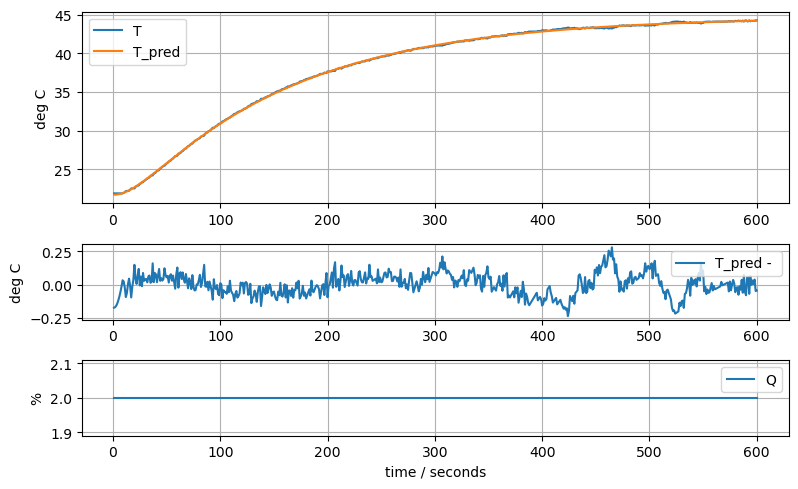

In [26]:
from scipy.integrate import odeint
from scipy.optimize import minimize

results = minimize(model_heater_sensor, param_heater_sensor, method='nelder-mead')
param_heater_sensor = results.x
model_heater_sensor(param_heater_sensor, plot=True)